## Image segmantation <img align="right" src="image/gistda.png" width="200" height="200">



<table class="ee-notebook-buttons" align="left">
    <td><a target="_parent"  href="https://nbviewer.org/github/Pathakorn40/rice-detection/blob/main/Tutorial/Image_segmentation.ipynb"><img width=26px src="https://upload.wikimedia.org/wikipedia/commons/thumb/3/38/Jupyter_logo.svg/883px-Jupyter_logo.svg.png" />Notebook Viewer</a></td>
</table>

This notebook demonstrates  methods for conducting [image segmentation](https://scikit-image.org/docs/stable/user_guide/tutorial_segmentation.html), which is a common image analysis technique used to transform a digital satellite image into objects. 
In brief, image segmentation aims to partition an image into segments, where each segment consists of a group of pixels with similar characteristics. 
A number of algorithms exist to perform image segmentation, one of which are shown here:

1. [Quickshift](https://scikit-image.org/docs/dev/api/skimage.segmentation.html#skimage.segmentation.quickshift), implemented through the python package `scikit-image`

### Load Packages

In [1]:
%matplotlib inline

from pystac_client import Client
from odc.stac import configure_rio, stac_load
from dask.distributed import Client as DaskClient
import matplotlib.pyplot as plt

import xarray as xr
import numpy as np
import scipy
import matplotlib.pyplot as plt
from osgeo import gdal
from skimage.segmentation import quickshift
from dream_river.plotimg import rgb
from dream_river.indices import cal_index

client = DaskClient()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 8,Total memory: 39.15 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:43927,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 8
Started: Just now,Total memory: 39.15 GiB
Comm: tcp://127.0.0.1:44291,Total threads: 2
Dashboard: http://127.0.0.1:36841/status,Memory: 9.79 GiB
Nanny: tcp://127.0.0.1:35795,


### Set Query Parameter for load data

In [2]:
bbox = [102.514, 15.052, 102.590, 15.113]
start_date = "2018-06-29"
end_date = "2018-06-30"
collections = ["LANDSAT8_SR_C2L2"]
config = {
    "LANDSAT8_SR_C2L2": {
        "assets": {
            "*": {
                "data_type": "uint16",
                "nodata": 0,
                "unit": "unitless",
            },
            "aerosol_qa": {
                "data_type": "uint8",
                "nodata": 0,
                "unit": "bit",
            },
            "pixel_qa": {
                "data_type": "uint16",
                "nodata": 0,
                "unit": "bit",
            },
            "radsat_qa": {
                "data_type": "uint16",
                "units": "bit",
                "nodata": 0,
            },
        },
    }
}

In [3]:
# connect to the GISTDA ODC STAC Catalog
catalog = Client.open(url="http://110.78.252.138/stac")
query = catalog.search(
    bbox=bbox, collections=collections, datetime=f"{start_date}/{end_date}"
)
items = list(query.items())
print(f"Found: {len(items):d} datasets")
for ds in items:
    print(ds.to_dict()['properties']['title'])

Found: 2 datasets
LC08_L2SR_128049_20180630_20200831_02_T1
LC08_L2SR_128050_20180630_20200831_02_T1


### Load data from datacube

In [4]:
# Loading data using stac_load()

ds = stac_load(
    items,
    bands=['blue','green','red',"nir"],
    stac_cfg=config,
    chunks={},
    groupby="solar_day",
    bbox=bbox,
)
ds

<xarray.Dataset> Size: 512kB
Dimensions:      (y: 230, x: 276, time: 1)
Coordinates:
  * y            (y) float64 2kB 1.672e+06 1.672e+06 ... 1.666e+06 1.665e+06
  * x            (x) float64 2kB 2.327e+05 2.328e+05 ... 2.41e+05 2.41e+05
    spatial_ref  int32 4B 32648
  * time         (time) datetime64[ns] 8B 2018-06-30T03:30:14
Data variables:
    blue         (time, y, x) uint16 127kB dask.array<chunksize=(1, 230, 276), meta=np.ndarray>
    green        (time, y, x) uint16 127kB dask.array<chunksize=(1, 230, 276), meta=np.ndarray>
    red          (time, y, x) uint16 127kB dask.array<chunksize=(1, 230, 276), meta=np.ndarray>
    nir          (time, y, x) uint16 127kB dask.array<chunksize=(1, 230, 276), meta=np.ndarray>

### Display study area

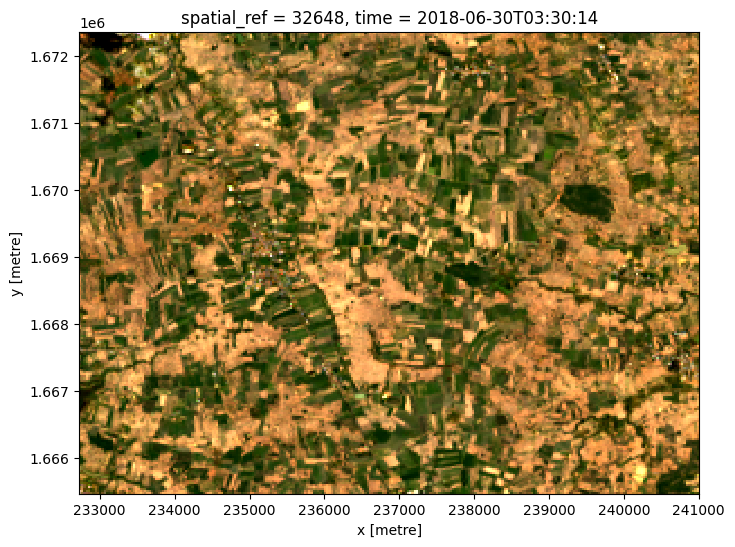

In [5]:
# Plot as an RGB image select first timestep 
rgb(ds, bands=['red','green', 'blue'], index=[0])

### Calculate NDVI index

In [12]:
# calculate ndvi
# First we calculate NDVI on each image in the timeseries
ds_index = cal_index(ds, index='NDVI', collection='ls8_collections_sr_scene')


In [14]:
ds_index

<xarray.Dataset> Size: 1MB
Dimensions:      (y: 230, x: 276, time: 1)
Coordinates:
  * y            (y) float64 2kB 1.672e+06 1.672e+06 ... 1.666e+06 1.665e+06
  * x            (x) float64 2kB 2.327e+05 2.328e+05 ... 2.41e+05 2.41e+05
    spatial_ref  int32 4B 32648
  * time         (time) datetime64[ns] 8B 2018-06-30T03:30:14
Data variables:
    blue         (time, y, x) uint16 127kB dask.array<chunksize=(1, 230, 276), meta=np.ndarray>
    green        (time, y, x) uint16 127kB dask.array<chunksize=(1, 230, 276), meta=np.ndarray>
    red          (time, y, x) uint16 127kB dask.array<chunksize=(1, 230, 276), meta=np.ndarray>
    nir          (time, y, x) uint16 127kB dask.array<chunksize=(1, 230, 276), meta=np.ndarray>
    NDVI         (time, y, x) float64 508kB dask.array<chunksize=(1, 230, 276), meta=np.ndarray>

In [15]:
# select first time_step of image
ds_plot = ds_index.NDVI.isel(time=0)

### Plot NDVI image

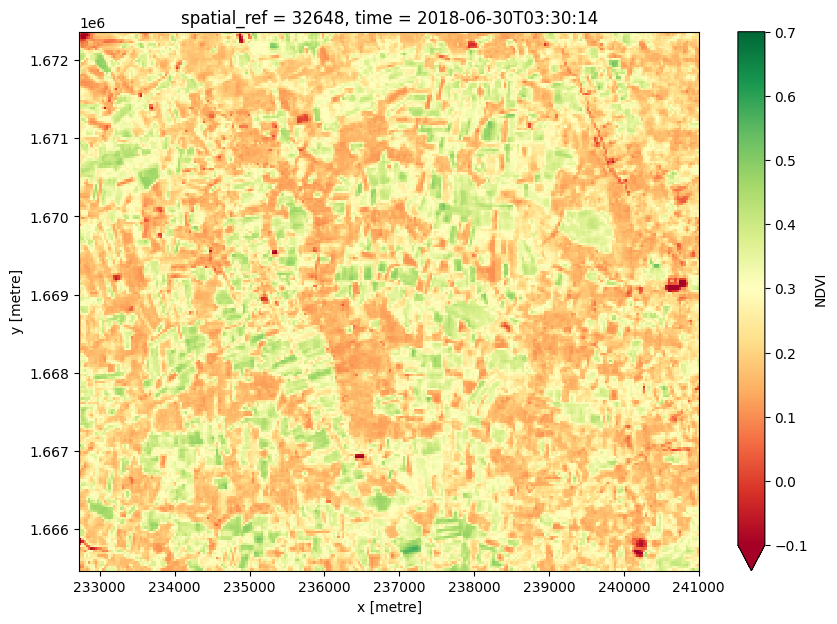

In [23]:
ds_plot.plot(vmin=-0.1, vmax=0.7, cmap = 'RdYlGn', figsize=(10, 7))

### Quickshift Segmentation

Using the function [quickshift](https://scikit-image.org/docs/dev/api/skimage.segmentation.html#skimage.segmentation.quickshift) from the python package `scikit-image`, we will conduct an image segmentation on the mean NDVI array.  We then calculate a zonal mean across each segment using the input dataset. Our last step is to export our results as a GeoTIFF.

Follow the quickshift hyperlink above to see the input parameters to the algorithm, and the following [link](https://scikit-image.org/docs/dev/auto_examples/segmentation/plot_segmentations.html) for an explanation of quickshift and other segmentation algorithms in `scikit-image`.

In [24]:
# Convert our mean NDVI xarray into a numpy array, we need
# to be explicit about the datatype to satisfy quickshift
input_array = ds_plot.values.astype(np.float64)

Code below, you can set your own parameters for image segmentation [Read here !!! how to set parameters](https://scikit-image.org/docs/dev/api/skimage.segmentation.html#skimage.segmentation.quickshift)

In [25]:
# Calculate the segments
segments = quickshift(input_array,
                      kernel_size=2,
                      convert2lab=False,
                      max_dist=2,
                      ratio=1.0)

In [26]:
# Calculate the zonal mean NDVI across the segments
segments_zonal_mean_qs = scipy.ndimage.mean(input=input_array,
                                            labels=segments,
                                            index=segments)

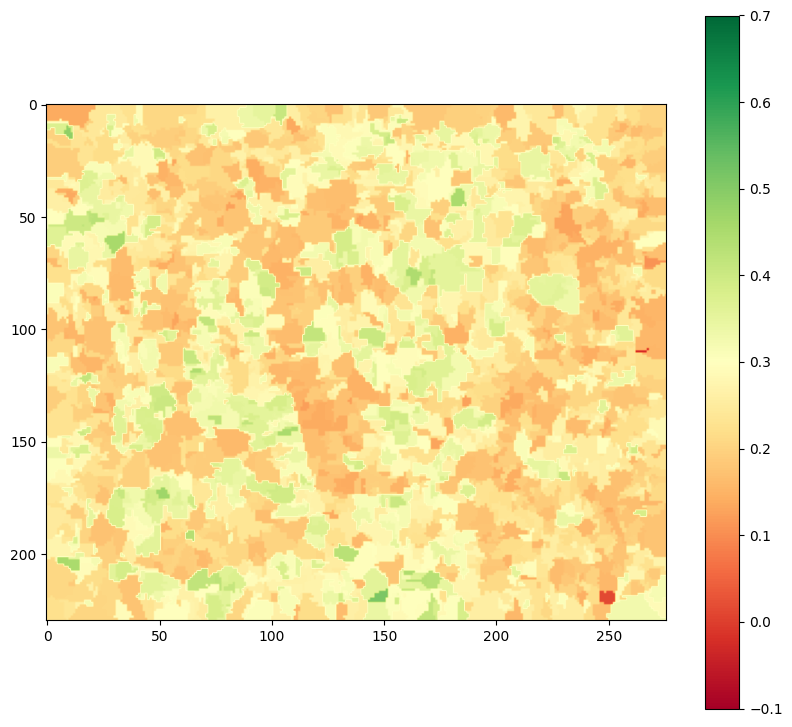

In [28]:
# Plot to see result
plt.figure(figsize=(10, 10))
plt.imshow(segments_zonal_mean_qs, cmap='RdYlGn', vmin=-0.1, vmax=0.7)
plt.colorbar(shrink=0.9)